# Supervised Learning In-Depth: Model selection

Previously we saw the main API shared by objects in scikit-learn and a couple of estimators, notably logistic regression and K-nearest neighbors.

In this session we will take a look at model selection, one of the most important aspects of applied machine learning.

In [1]:
# some imports
%pylab inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 30


# numpy
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Overfitting, Underfitting and Model Selection


The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more training samples?

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

### Illustration of the Bias-Variance Tradeoff

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [2]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [3]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

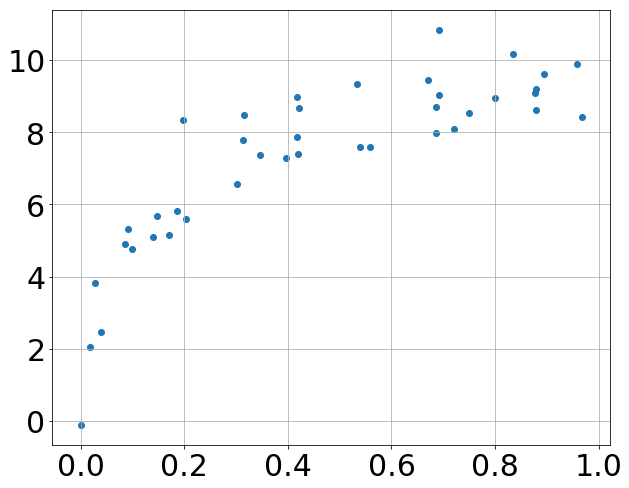

In [4]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y)
plt.grid()
plt.show()


Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

mean squared error: 1.79


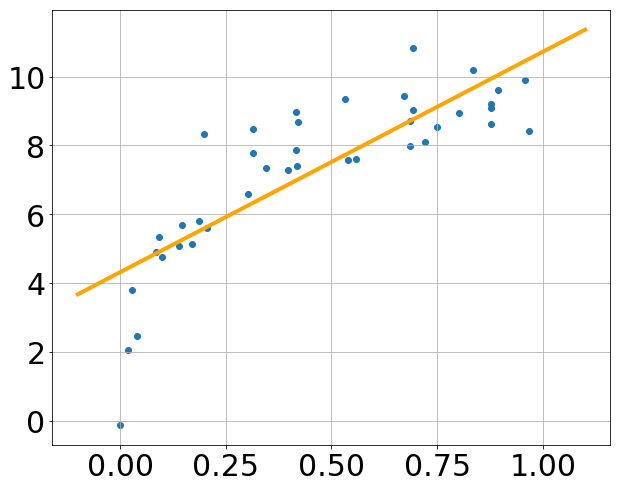

In [5]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

print("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.scatter(X.ravel(), y, label='original data')
plt.plot(X_test.ravel(), y_test, label='estimated model', lw=4, color='orange')
plt.grid()
plt.show()


We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Scikit-learn makes this easy with the ``PolynomialFeatures`` preprocessor, which can be pipelined with a linear regression.

Let's make a convenience routine to do this:

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now we'll use this to fit a quadratic curve to the data.

mean squared error: 0.92


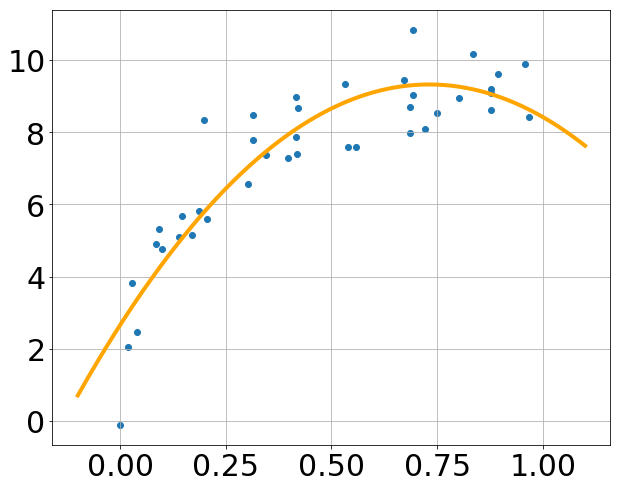

In [7]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)


print("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))

plt.scatter(X.ravel(), y, label='initial data')
plt.plot(X_test.ravel(), y_test, label='estimated model', lw=4, color='orange')
plt.grid()
plt.show()

# iplot([go.Scatter(x=X.ravel(), y=y, mode='markers'),
#         go.Scatter(x=X_test.ravel(), y=y_test, name='estimated model')])


This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

mean squared error: 0.559


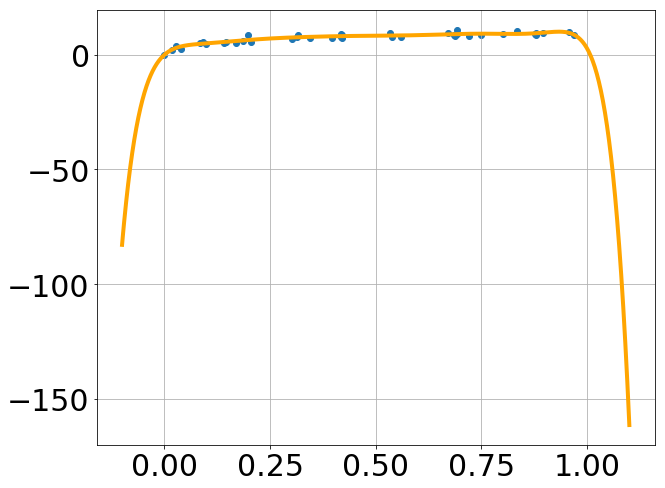

In [9]:
model = PolynomialRegression(10)
model.fit(X, y)
y_test = model.predict(X_test)

print("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))


plt.scatter(X.ravel(), y, label='original data')
plt.plot(X_test.ravel(), y_test, label='estimated model', lw=4, color='orange')
plt.grid()
plt.show()


When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

### Detecting Over-fitting with Validation Curves

Clearly, computing the error on the training data is not enough (we saw this previously). As above, we can use **cross-validation** to get a better handle on how the model fit is working.

Let's do this here, again using the ``validation_curve`` utility. To make things more clear, we'll use a slightly larger dataset:

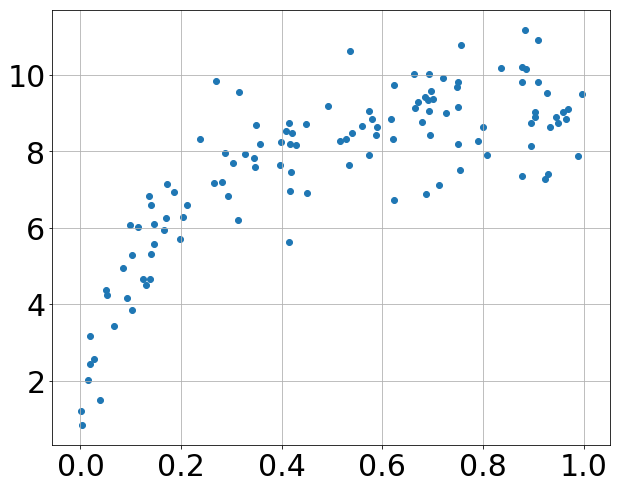

In [13]:
X, y = make_data(120, error=1.0)
plt.scatter(X.ravel(), y, label='input data')
plt.grid()
plt.show()

In [14]:
from sklearn.learning_curve import validation_curve

degree = np.arange(0, 15)
val_train, val_test = validation_curve(
    PolynomialRegression(), X, y, 'polynomialfeatures__degree', degree, cv=7)

In [15]:
val_train.mean(1)

array([ 0.        ,  0.58852789,  0.76805382,  0.80094758,  0.81918477,
        0.8203819 ,  0.82081399,  0.82086485,  0.82139841,  0.82623171,
        0.82669214,  0.82688681,  0.82742251,  0.82768772,  0.83099568])

Now let's plot the validation curves:

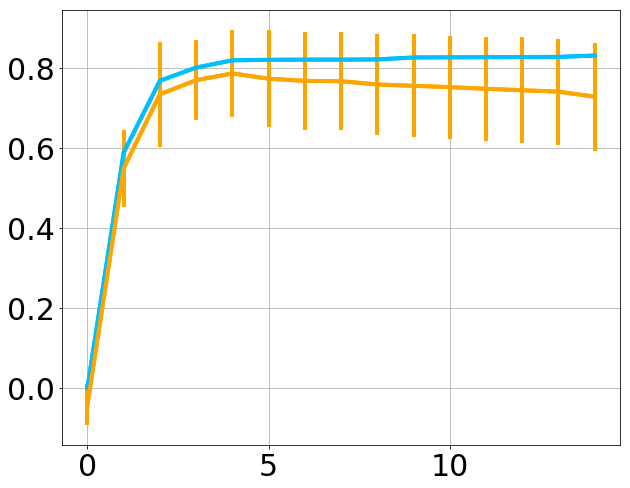

In [16]:
plt.plot(degree, val_train.mean(1), color='deepskyblue', lw=4, label='train error')
plt.errorbar(degree, val_train.mean(1), yerr=val_train.std(1), color='deepskyblue', lw=4)
plt.plot(degree, val_test.mean(1), lw=4, color='orange')
plt.errorbar(degree, val_test.mean(1), yerr=val_test.std(1), color='orange', lw=4)
plt.grid()
plt.show()

Notice the trend here, which is common for this type of plot.

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

# <span style='color: red'>__Tip__</span>: in the final report you should must include these plots.

Here's our best-fit model according to the cross-validation:

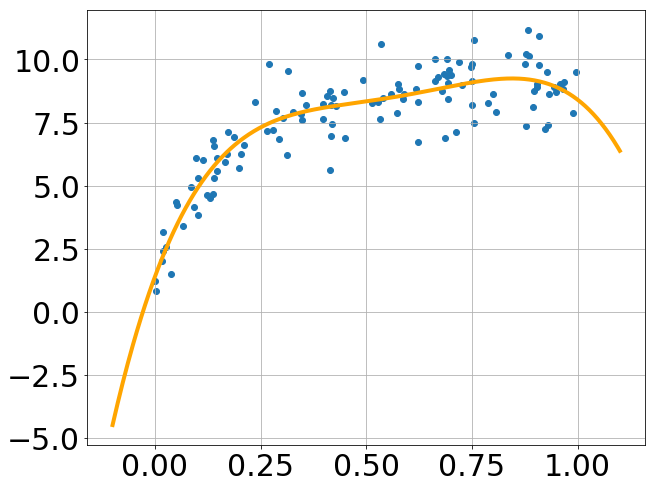

In [17]:
model = PolynomialRegression(4).fit(X, y)

plt.scatter(X.ravel(), y, label='original data')
plt.plot(X_test.ravel(), model.predict(X_test), label='estimated model', lw=4, color='orange')
plt.grid()
plt.show()


### Other hyperparameters


```LogisticRegression``` has a ```C``` parameter that needs to be chosen. Contrary to before, this is a continuous hyperparameter. Here, we plot validation curve for this hyperparameter, with 10 values between $10^-6$ and $10^6$ in log scale.


In [18]:
# setup code for exercise
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import validation_curve

Cs = np.logspace(-6, 6, 10)
val_train, val_test = validation_curve(LogisticRegression(), X_digits, y_digits,
                                       'C', Cs, cv=7)



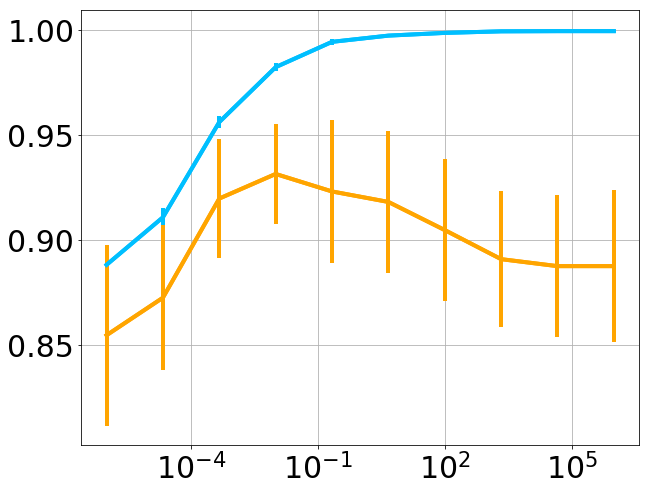

In [20]:
plt.plot(Cs, val_train.mean(1), color='deepskyblue', lw=4, label='train error')
plt.errorbar(Cs, val_train.mean(1), yerr=val_train.std(1), color='deepskyblue', lw=4)
plt.plot(Cs, val_test.mean(1), lw=4, color='orange')
plt.errorbar(Cs, val_test.mean(1), yerr=val_test.std(1), color='orange', lw=4)
plt.grid()
plt.xscale('log')
plt.show()

---

### Automatically choose the best hyperparameter

We can use the above curves to choose the best hyperparameters for our model. We can simply iterate through the validation curve and select the best hyperparameter. However, there is a better way in scikit-learn: through the ```GridSearchCV``` object.

This is an object that, given data, computes the score during the fit of an estimator on a parameter grid and chooses the parameters to maximize the cross-validation score. This object takes an estimator during the construction and exposes an estimator API:


In [21]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# get some data
digits = datasets.load_digits()
X = digits.data
y = digits.target

# define the different hyperparameters
Cs = np.logspace(-6, -1, 10)
print(Cs)

[  1.00000000e-06   3.59381366e-06   1.29154967e-05   4.64158883e-05
   1.66810054e-04   5.99484250e-04   2.15443469e-03   7.74263683e-03
   2.78255940e-02   1.00000000e-01]


In [22]:
# call GridSearchCV with a LogisticRegression estimator, but choosing
# C out of all Cs
from sklearn.linear_model import LogisticRegression
clf = GridSearchCV(estimator=LogisticRegression(), param_grid=dict(C=Cs))
clf.fit(X, y)        

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

So under the hood, ```GridSearchCV``` has:

  * Tried out all values of ```C``` in Cs.
  * Selected by cross-validation the one with best score.

Once fitted, the ```GridSearchCV``` behaves like any other estimator. Like any other estimator it implements a .predict and .score method.

In [23]:
clf.predict(X)

array([0, 1, 2, ..., 8, 9, 8])

In [24]:
clf.score(X, y)

0.97941012799109628

```GridSearchCV``` is what we call a **meta-estimator**: it behaves like an estimator but it is in fact made up from one or several estimators. This is a powerful concept!

How to retrieve the optimal value of C that was selected by ```GridSearchCV```? ```GridSearchCV``` has a member ```clf.best_estimator_``` that returns which was the best estimator.

In [25]:
clf.best_estimator_

LogisticRegression(C=0.0077426368268112772, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Exercise 1


**Multi-layer Perceptron (MLP)** is a supervised learning algorithm that learns
a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset,
where $m$ is the number of dimensions for input and $o$ is the
number of dimensions for output. Given a set of features $X = \{x_1, x_2, ..., x_m\}$
and a target $y$, it can learn a non-linear function approximator for either
classification or regression. It is different from logistic regression, in that
between the input and the output layer, there can be one or more non-linear
layers, called hidden layers. This represents one hidden layer MLP with scalar
output.

<img src="http://scikit-learn.org/stable/_images/multilayerperceptron_network.png" width=400/>


On the digits dataset, build a neural network model, [MLPCLassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) and:
  * choose the best possible parameters of ```alpha``` using ```GridSearchCV```.
  * choose the best possible parameter for ```hidden_layer_sizes```.

---

## Pipelines or combining different classifiers

At some point, you might want to combine some preprocessing (like feature selection) with a classifier. It is possible to do this manually:

In [26]:
# get some data
from sklearn import datasets
digits = datasets.load_digits()
X = digits.data
y = digits.target


from sklearn import decomposition
# select only 10 features
pca = decomposition.PCA(n_components=10)
X_trans = pca.fit_transform(X)


# now train the classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_trans, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
X_trans.shape

(1797, 10)

In [28]:
X.shape

(1797, 64)

But this soon becomes tedious when dealing with cross-validation. A better solution is to create a Pipeline:

In [29]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(
    decomposition.PCA(n_components=10), LogisticRegression())
clf.fit(X, y)
print(clf.score(X, y))

0.927657206455


### Exercise

Create a Pipeline with PCA and LogisticRegression, plot performance as the number of dimensions (```n_components```) by cross-validation and get the optimum using GridSearchCV.

## Summary

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **GridSearchCV** is an object that encapsulates the logic of performing model selection.
  + By specifying the different values of the parameter, he will try them out and keep the best.
  + The resulting object is a 
  
These tools are powerful means of evaluating your model on your data.

<small><i>This notebook was put together by Fabian Pedregosa based on work by [Jake Vanderplas](http://www.vanderplas.com).</i></small>